# Brain tumor detection using CNN

dataset link: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

## Importing necessary packages

In [229]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys
import os
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

## Reading the images

In [230]:
data_dir = "data/brain_tumor_dataset"  # path of dataset
tumor = []
healthy = []
 
for label, folder in enumerate(['no', 'yes']):
    folder_path = os.path.join(data_dir, folder)                  # folder path for no and yes folders
    for fname in os.listdir(folder_path):
        fname = os.path.join(folder_path,fname)                   # folder path of images
        if fname.endswith(('.jpg','.JPG' ,'.jpeg', '.png')):
            img = cv2.imread(fname)                               # read image 
            img = cv2.resize(img,(128,128))                       # resize image to 128x128
            b, g, r = cv2.split(img)                              # split images to its rgb channels
            img = cv2.merge([r,g,b])                              # merge channel in right order
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            if folder == "no":
                healthy.append(img)                               
            else:
                tumor.append(img)

In [231]:
# convert lists to numpy array and concatenate 
healthy = np.array(healthy,dtype=np.float32)
tumor = np.array(tumor,dtype=np.float32)

# our labels
tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

In [232]:
healthy.shape

(98, 3, 128, 128)

In [233]:
tumor.shape

(155, 3, 128, 128)

In [234]:
np.random.choice(10, 5, replace=False)

array([6, 8, 9, 7, 2])

## Create Torch Dataset Class

### PyTrorch abstract dataset class

In [235]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

### Creating BrainMRDataset custom dataset class

In [236]:
class BrainMrDataset(Dataset):
    def __init__(self,tumor,healthy):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
    
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, index):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[index], 'label': self.y_train[index]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[index], 'label': self.y_val[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

## Creating Model

In [237]:
import torch.nn as nn
import torch.nn.functional as F

In [238]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # first conv. layer 
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # batch normalization for first layer
        self.bn1 = nn.BatchNorm2d(32)
        # activation func.
        self.relu = nn.ReLU()
        # using avg pooling
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        # second conv. layer
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # batch normalization for first layer
        self.bn2 = nn.BatchNorm2d(64)
        # Third convolutional block
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # batch normalization for third layer
        self.bn3 = nn.BatchNorm2d(128)

         # Adaptive Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # fully connected layers
        self.fc1 = nn.Linear(in_features=128, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, out):
        # First block
        out = self.cnn1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxPool(out)

        # Second block
        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.maxPool(out)

        # Third block
        out = self.cnn3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.maxPool(out)
        
        # Global average pooling
        out = self.global_avg_pool(out)
        
        # flatten our images
        out = out.view(out.size(0), -1)
        """ 
            .size method return (number of batches, number of channels, x , y) 
            for our example size is (32, 3, 128, 128) 32 images that has 3 channels and size of images is 128x128
            x.size(0) is  number of samples in a batch(size of a batch) 

            The -1 is a special value in PyTorch that tells the view function to automatically infer the size of this dimension

            The view function reshapes the tensor without changing its data. The total number of elements in the tensor remains the same. 
            flatten images independently ***
            For example, if out originally has a shape of (batch_size, channels, height, width), the view call will reshape it to (batch_size, channels * height * width)
            if we have a tensor that size of (2, 2, 2, 2)
            x.view(x.size(0), -1).shape   =>  2,8 
        """

        # forward to the fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = F.sigmoid(out)

        return out

In [239]:
model = CNN()

In [240]:
model

CNN(
  (cnn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Training Model

In [241]:
dataset = BrainMrDataset(tumor, healthy)
dataset.normalize()
dataset.train_val_split()

In [242]:
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [243]:
device = torch.device("cuda:0")
model = CNN().to(device)

In [244]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [245]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [246]:
for epoch in range(1,50):
    train_losses = []
    # train for the current epoch
    model.train()
    dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    
    print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 2	Train Loss: 0.685839	Val Loss: 0.693112
Train Epoch: 3	Train Loss: 0.677049	Val Loss: 0.691561
Train Epoch: 4	Train Loss: 0.680158	Val Loss: 0.688882
Train Epoch: 5	Train Loss: 0.656651	Val Loss: 0.683033
Train Epoch: 6	Train Loss: 0.661410	Val Loss: 0.671648
Train Epoch: 7	Train Loss: 0.634668	Val Loss: 0.659976
Train Epoch: 8	Train Loss: 0.631664	Val Loss: 0.649500
Train Epoch: 9	Train Loss: 0.625174	Val Loss: 0.640928
Train Epoch: 10	Train Loss: 0.613663	Val Loss: 0.635377
Train Epoch: 11	Train Loss: 0.612238	Val Loss: 0.627821
Train Epoch: 12	Train Loss: 0.602971	Val Loss: 0.621814
Train Epoch: 13	Train Loss: 0.616850	Val Loss: 0.616640
Train Epoch: 14	Train Loss: 0.613448	Val Loss: 0.611820
Train Epoch: 15	Train Loss: 0.599592	Val Loss: 0.606238
Train Epoch: 16	Train Loss: 0.580114	Val Loss: 0.603417
Train Epoch: 17	Train Loss: 0.592605	Val Loss: 0.597642
Train Epoch: 18	Train Loss: 0.578148	Val Loss: 0.589354
Train Epoch: 19	Train Loss: 0.562185	Val Loss: 0.584767


Text(0, 0.5, 'Loss')

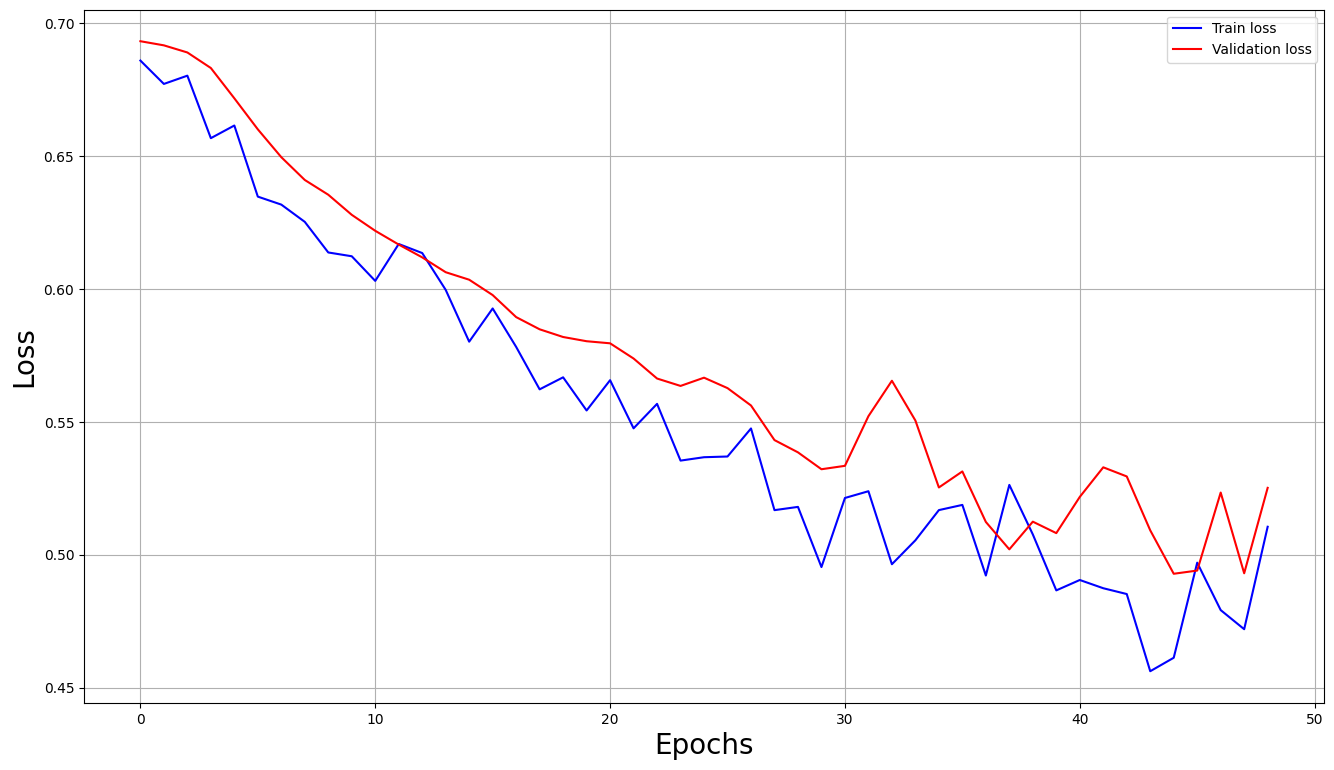

In [247]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)